In [1]:
from IPython import get_ipython
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt

from glob import glob
from tifffile import imread
from csbdeep.utils import Path, download_and_extract_zip_file
from skimage.segmentation import find_boundaries

from stardist import edt_prob, star_dist, fill_label_holes
from stardist import random_label_cmap, draw_polygons, ray_angles

from stardist.nms import _non_maximum_suppression_old as non_maximum_suppression
from stardist.geometry import _dist_to_coord_old as dist_to_coord
from stardist.geometry import _polygons_to_label_old as polygons_to_label

from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, download_and_extract_zip_file

from stardist import fill_label_holes, relabel_image_stardist, random_label_cmap, gputools_available
from stardist.matching import matching_dataset
np.random.seed(42)
lbl_cmap = random_label_cmap()



#import torch
#torch.cuda.current_device()


In [2]:
X = sorted(glob('/scicore/home/pissal00/ercan0000/220310_training/stardist/ground_truth/train/images/*.tif'))
Y = sorted(glob('/scicore/home/pissal00/ercan0000/220310_training/stardist/ground_truth/train/masks/*.tif'))
assert all(Path(x).name==Path(y).name for x,y in zip(X,Y))



X_v = sorted(glob('/scicore/home/pissal00/ercan0000/220310_training/stardist/ground_truth/validation/images/*.tif'))
Y_v = sorted(glob('/scicore/home/pissal00/ercan0000/220310_training/stardist/ground_truth/validation/masks/*.tif'))
assert all(Path(x).name==Path(y).name for x,y in zip(X_v, Y_v))



X = list(map(imread,X))
Y = list(map(imread,Y))



X_v = list(map(imread,X_v))
Y_v = list(map(imread,Y_v))

In [3]:

i = min(2, len(X)-1)
img, lbl = X[i], fill_label_holes(Y[i])
assert img.ndim in (2,3)
img = img if img.ndim==2 else img[...,:3]


n_rays = 32
prob = edt_prob(lbl)
dist = star_dist(lbl, n_rays)

In [4]:

coord = dist_to_coord(dist)


# Perform non-maximum suppression to retain one polygon for each instance:


points = non_maximum_suppression(coord, prob, prob_thresh=0.5)


# Convert polygons to label image:


labels = polygons_to_label(coord, prob, points)



In [5]:




import sys
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.matching import matching_dataset
from stardist.models import Config2D, StarDist2D, StarDistData2D



#n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]
n_channel = 3


axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()
    
X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
Y = [fill_label_holes(y) for y in tqdm(Y)]
X_v = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X_v)]
Y_v = [fill_label_holes(y) for y in tqdm(Y_v)]


Using TensorFlow backend.


Normalizing image channels independently.


100%|██████████| 24/24 [00:04<00:00,  5.17it/s]


In [6]:

X_val, Y_val = [X_v[i] for i in  range(0,len(X_v))]  , [Y_v[i] for i in range(0,len(Y_v))]
X_trn, Y_trn = [X[i] for i in range(0,len(X))]  , [Y[i] for i in range(0,len(Y))]



print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))


- training:       117
- validation:      24


In [7]:
def plot_img_label(img,lbl, img_title = "image", lbl_title = "label", **kwargs):
    plt.figure(figsize=(12,8))
    plt.subplot(121); 
    im = plt.imshow(img,cmap='gray', clim  =(0,1));   
    plt.title(img_title)    
    divider = make_axes_locatable(plt.gca())
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im, cax=cax)
    plt.subplot(122); 
    plt.imshow(lbl,cmap=lbl_cmap); 
    plt.title(lbl_title)

In [8]:
model = StarDist2D(None, name='stardist_final2', basedir='/scicore/home/pissal00/ercan0000/220310_training/stardist/output/models')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.57276, nms_thresh=0.3.


In [10]:
model.optimize_thresholds(X_val, Y_val)


NMS threshold = 0.3:  75%|███████▌  | 15/20 [04:51<01:37, 19.42s/it, 0.575 -> 0.850]

NMS threshold = 0.4:  75%|███████▌  | 15/20 [04:48<01:36, 19.20s/it, 0.575 -> 0.849]

NMS threshold = 0.5:  75%|███████▌  | 15/20 [04:49<01:36, 19.31s/it, 0.575 -> 0.848]


Using optimized values: prob_thresh=0.57276, nms_thresh=0.3.
Saving to 'thresholds.json'.


{'prob': 0.5727598688348611, 'nms': 0.3}

In [9]:
Y_val_pred = [model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0]
              for x in tqdm(X_val)]

  0%|          | 0/24 [00:00<?, ?it/s]

100%|██████████| 24/24 [08:17<00:00, 20.74s/it]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


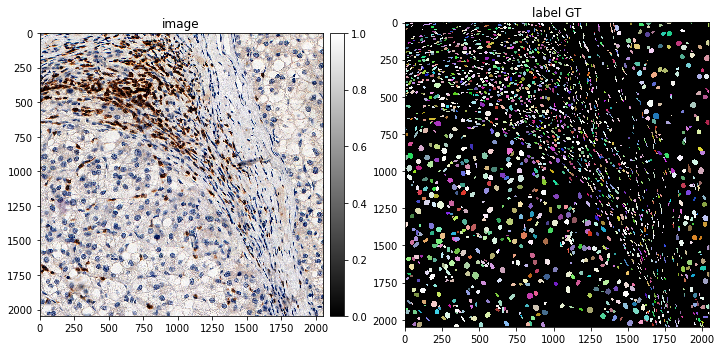

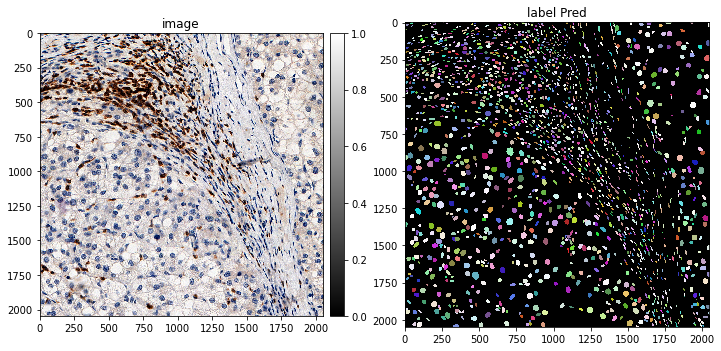

In [13]:
plot_img_label(X_val[1],Y_val[1], lbl_title="label GT")
plot_img_label(X_val[1],Y_val_pred[1], lbl_title="label Pred")

In [10]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(Y_val, Y_val_pred, thresh=t, show_progress=False) for t in tqdm(taus)]

100%|██████████| 9/9 [01:05<00:00,  7.26s/it]


In [11]:
stats[taus.index(0.7)]

DatasetMatching(criterion='iou', thresh=0.7, fp=3704, tp=31192, fn=4473, precision=0.8938560293443375, recall=0.8745829244357213, accuracy=0.792298508979146, f1=0.8841144541602302, n_true=35665, n_pred=34896, mean_true_score=0.7865062632868906, mean_matched_score=0.8992929558901948, panoptic_quality=0.7950779008269995, by_image=False)

In [12]:
stats[taus.index(0.5)]

DatasetMatching(criterion='iou', thresh=0.5, fp=2100, tp=32796, fn=2869, precision=0.9398211829436038, recall=0.9195569886443292, accuracy=0.8684231431219384, f1=0.9295786624339224, n_true=35665, n_pred=34896, mean_true_score=0.8146267025497139, mean_matched_score=0.8858903935368809, panoptic_quality=0.823504807087075, by_image=False)

In [15]:
stats[taus.index(0.3)]

DatasetMatching(criterion='iou', thresh=0.3, fp=1702, tp=33194, fn=2471, precision=0.9512265016047684, recall=0.9307163886162905, accuracy=0.8883239221773223, f1=0.9408596816938536, n_true=35665, n_pred=34896, mean_true_score=0.819387081076182, mean_matched_score=0.880383209211967, panoptic_quality=0.8283170659877845, by_image=False)

In [16]:
stats[taus.index(0.2)]

DatasetMatching(criterion='iou', thresh=0.2, fp=1659, tp=33237, fn=2428, precision=0.952458734525447, recall=0.9319220524323567, accuracy=0.8904994105669275, f1=0.942078485282238, n_true=35665, n_pred=34896, mean_true_score=0.8196923852083845, mean_matched_score=0.8795718301428237, panoptic_quality=0.8286256974378773, by_image=False)

Example: Print all available matching statistics for $\tau=0.5$

Plot the matching statistics and the number of true/false positives/negatives as a function of the IoU threshold $\tau$. 

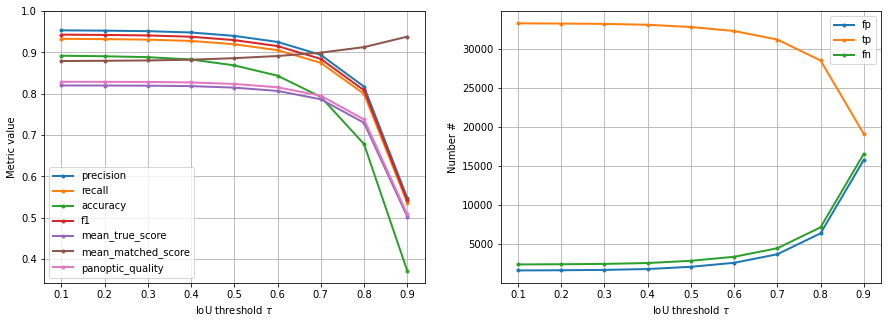

In [17]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()
ax1.set_ylim(top=1)

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend();

In [13]:
modelPre = StarDist2D(None, name='python_2D_versatile_he', basedir='/scicore/home/pissal00/ercan0000/phd_models/Stardist/ultimate211124')

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


First predict the labels for all validation images:

In [14]:
Y_val_pred_pre = [modelPre.predict_instances(x, n_tiles=modelPre._guess_n_tiles(x), show_tile_progress=False)[0]
              for x in tqdm(X_val)]

100%|██████████| 24/24 [04:30<00:00, 11.27s/it]


Plot a GT/prediction example 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


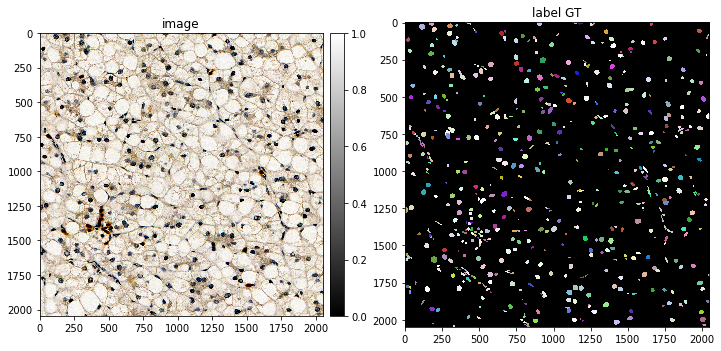

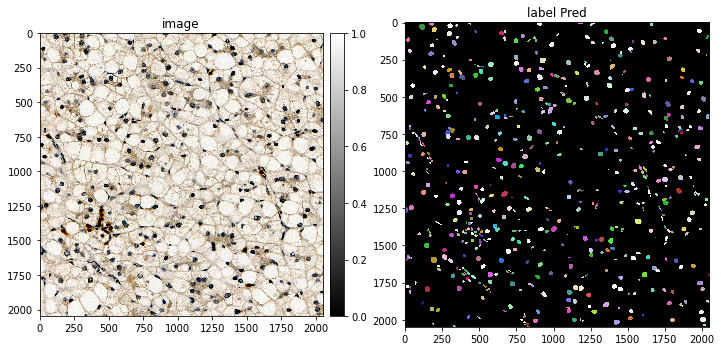

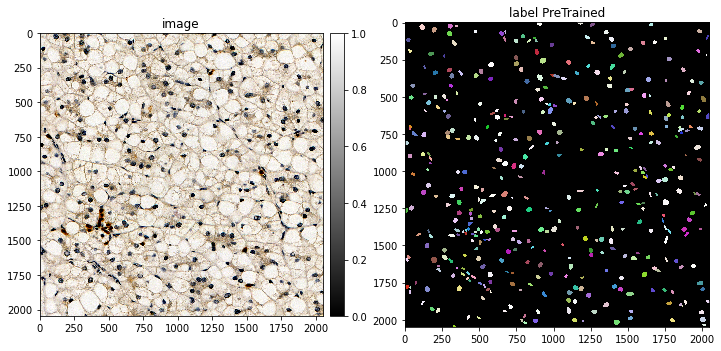

In [21]:
plot_img_label(X_val[0],Y_val[0], lbl_title="label GT")
plot_img_label(X_val[0],Y_val_pred[0], lbl_title="label Pred")
plot_img_label(X_val[0],Y_val_pred_pre[0], lbl_title="label PreTrained")

Choose several IoU thresholds $\tau$ that might be of interest and for each compute matching statistics for the validation data.

In [16]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats_pre = [matching_dataset(Y_val, Y_val_pred_pre, thresh=t, show_progress=False) for t in tqdm(taus)]

100%|██████████| 9/9 [00:55<00:00,  6.13s/it]


In [17]:
stats_pre

[DatasetMatching(criterion='iou', thresh=0.1, fp=234, tp=25082, fn=10583, precision=0.9907568336230053, recall=0.7032665077807374, accuracy=0.6986824145519374, f1=0.822616880667749, n_true=35665, n_pred=25316, mean_true_score=0.5650834060427218, mean_matched_score=0.8035124661715043, panoptic_quality=0.6609829184996531, by_image=False),
 DatasetMatching(criterion='iou', thresh=0.2, fp=269, tp=25047, fn=10618, precision=0.9893743087375573, recall=0.7022851535118464, accuracy=0.6970278844548339, f1=0.8214689821419786, n_true=35665, n_pred=25316, mean_true_score=0.5649247685438717, mean_matched_score=0.8044093851605856, panoptic_quality=0.6607973588533211, by_image=False),
 DatasetMatching(criterion='iou', thresh=0.3, fp=369, tp=24947, fn=10718, precision=0.9854242376362774, recall=0.6994812841721576, accuracy=0.6923183659876783, f1=0.8181892720683491, n_true=35665, n_pred=25316, mean_true_score=0.5642054957961127, mean_matched_score=0.8066055640986235, panoptic_quality=0.6599560193361329

In [15]:
stats_pre[taus.index(0.7)]

NameError: name 'stats_pre' is not defined

In [ ]:
stats_pre[taus.index(0.5)]

In [25]:
stats_pre[taus.index(0.3)]

DatasetMatching(criterion='iou', thresh=0.3, fp=369, tp=24947, fn=10718, precision=0.9854242376362774, recall=0.6994812841721576, accuracy=0.6923183659876783, f1=0.8181892720683491, n_true=35665, n_pred=25316, mean_true_score=0.5642054495897698, mean_matched_score=0.8066054980406118, panoptic_quality=0.6599559652881763, by_image=False)

In [26]:
stats_pre[taus.index(0.2)]

DatasetMatching(criterion='iou', thresh=0.2, fp=269, tp=25047, fn=10618, precision=0.9893743087375573, recall=0.7022851535118464, accuracy=0.6970278844548339, f1=0.8214689821419786, n_true=35665, n_pred=25316, mean_true_score=0.5649247223375289, mean_matched_score=0.8044093193663101, panoptic_quality=0.6607973048053646, by_image=False)

Example: Print all available matching statistics for $\tau=0.5$

Plot the matching statistics and the number of true/false positives/negatives as a function of the IoU threshold $\tau$. 

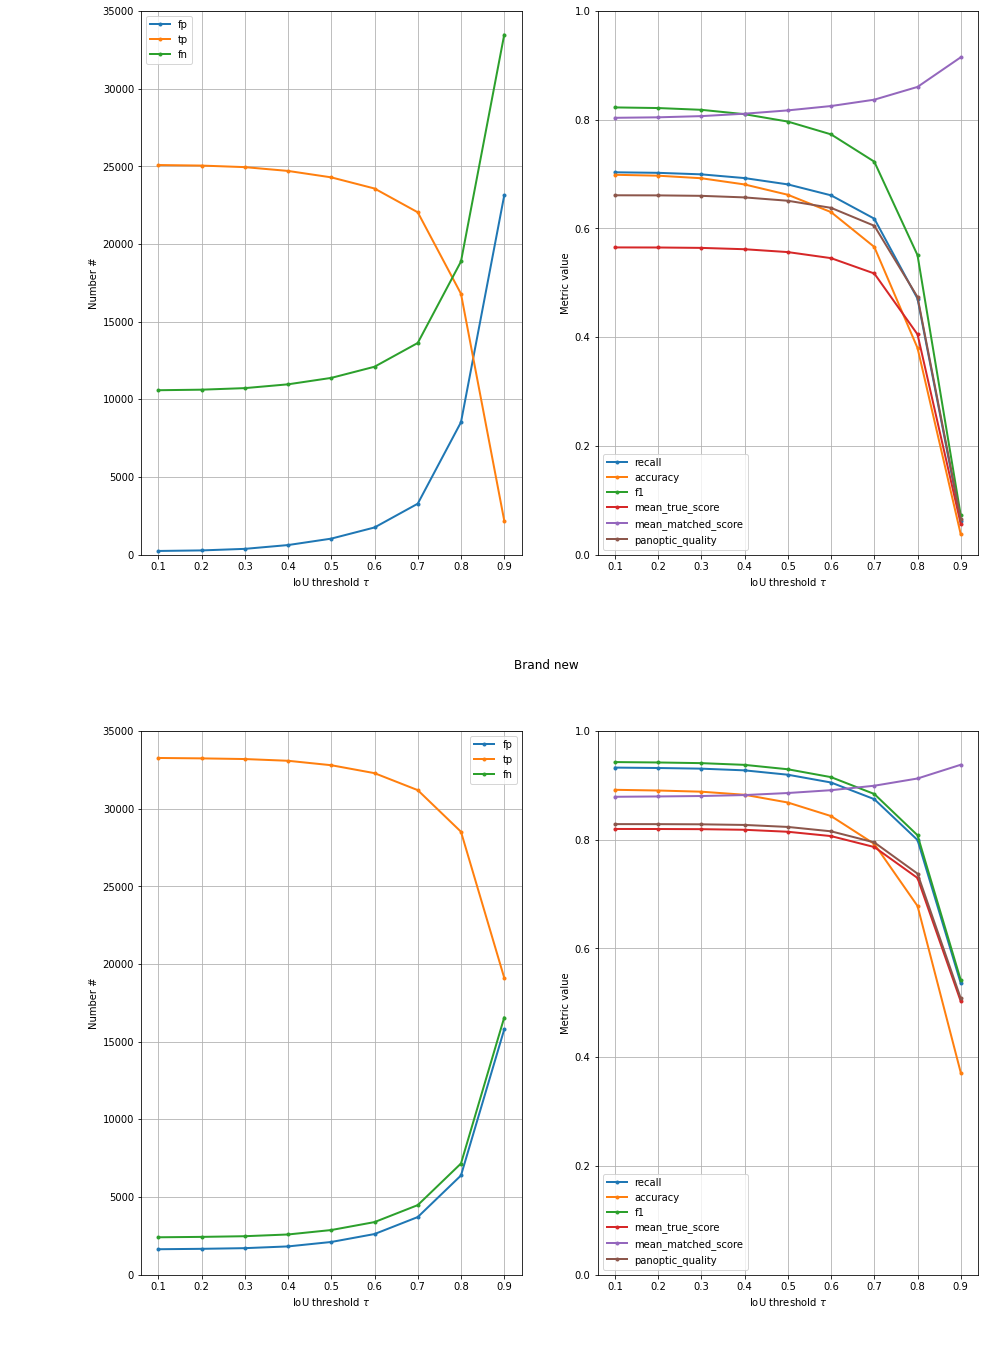

In [18]:
# create 3x1 subplots
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(15,20))
#fig.suptitle('Metrics')

# clear subplots
for ax in axs:
    ax.remove()

# add subfigure per subplot
gridspec = axs[0].get_subplotspec().get_gridspec()
subfigs = [fig.add_subfigure(gs) for gs in gridspec]

for row, subfig in enumerate(subfigs):
    if row == 1:
        subfig.suptitle('Brand new')
    else:
        subfig.suptitle('Pretrained')

    # create 1x3 subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=2)
    for col, ax in enumerate(axs):
        if row == 1:
            if col == 1:
                for m in ('recall', 'accuracy', 'f1', 'mean_true_score','mean_matched_score', 'panoptic_quality'):
                    ax.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
                ax.set_xlabel(r'IoU threshold $\tau$')
                ax.set_ylabel('Metric value')
                ax.grid()
                ax.legend()
                ax.set_ylim(top=1, bottom=0)
            else:
                for m in ('fp', 'tp', 'fn'):
                    ax.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
                ax.set_xlabel(r'IoU threshold $\tau$')
                ax.set_ylabel('Number #')
                ax.grid()
                ax.legend();
                ax.set_ylim(top=35000,bottom=0);
        else:
            if col == 1:
                for m in ('recall', 'accuracy', 'f1', 'mean_true_score','mean_matched_score', 'panoptic_quality'):
                    ax.plot(taus, [s._asdict()[m] for s in stats_pre], '.-', lw=2, label=m)
                ax.set_xlabel(r'IoU threshold $\tau$')
                ax.set_ylabel('Metric value')
                ax.grid()
                ax.legend()
                ax.set_ylim(top=1, bottom=0)
            else:
                for m in ('fp', 'tp', 'fn'):
                    ax.plot(taus, [s._asdict()[m] for s in stats_pre], '.-', lw=2, label=m)
                ax.set_xlabel(r'IoU threshold $\tau$')
                ax.set_ylabel('Number #')
                ax.grid()
                ax.legend()
                ax.set_ylim(top=35000,bottom=0);

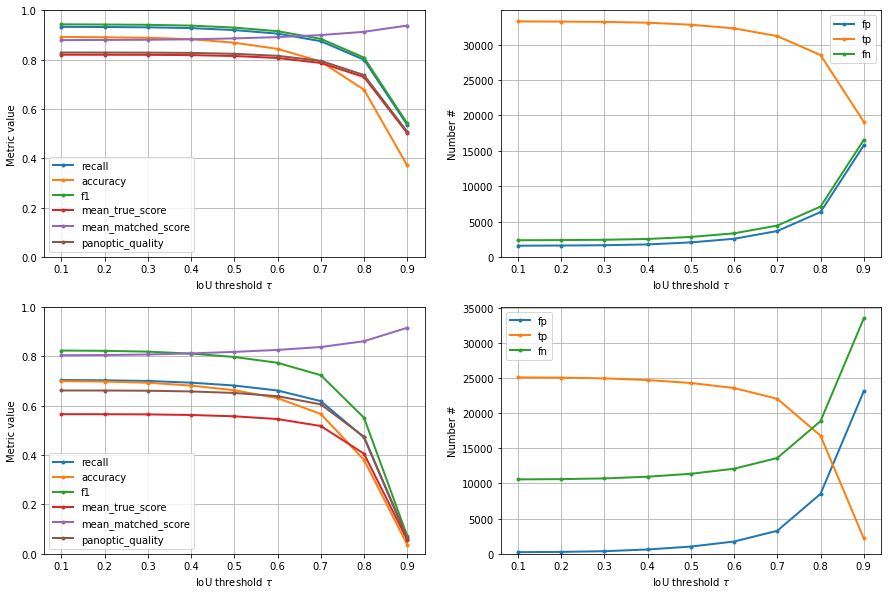

In [29]:

#ax11, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5)) 

fig, ((ax1, ax2), (ax3, ax4))  = plt.subplots(2,2, figsize=(15,10))

for m in ('recall', 'accuracy', 'f1', 'mean_true_score','mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()
ax1.set_ylim(top=1, bottom=0)



for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend();
ax2.set_ylim(bottom=0);

#fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))
#ax22, (ax3, ax4) = plt.subplots(1,2, figsize=(15,5)) 

for m in ('recall', 'accuracy', 'f1', 'mean_true_score','mean_matched_score', 'panoptic_quality'):
    ax3.plot(taus, [s._asdict()[m] for s in stats_pre], '.-', lw=2, label=m)
ax3.set_xlabel(r'IoU threshold $\tau$')
ax3.set_ylabel('Metric value')
ax3.grid()
ax3.legend()
ax3.set_ylim(top=1, bottom=0)

for m in ('fp', 'tp', 'fn'):
    ax4.plot(taus, [s._asdict()[m] for s in stats_pre], '.-', lw=2, label=m)
ax4.set_xlabel(r'IoU threshold $\tau$')
ax4.set_ylabel('Number #')
ax4.grid()
ax4.legend()
ax4.set_ylim(bottom=0);

In [30]:

ModelPath="/scicore/home/pissal00/ercan0000/220310_training/stardist/output/models/"
ModelName="final220319_bs2"
Export = ModelPath+ModelName
model.export_TF(fname = Export)



  8%|▊         | 2/24 [45:13<8:17:31, 1356.88s/it]



Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.


INFO:tensorflow:SavedModel written to: /scratch/ercan0000/slurm-job.46755297/tmp58xj18i7/model/saved_model.pb


----
STOP
----

In [26]:
# model name and path
#@markdown ###Do you want to assess the model you just trained ?
import os

#Here we define the loaded model name and path
QC_model_name = 'stardist'
QC_model_path = '/scicore/home/pissal00/ercan0000/cellDetection/ultimate211124/models'


full_QC_model_path = QC_model_path+'/'+QC_model_name+'/'
if os.path.exists(full_QC_model_path):
  print("The "+QC_model_name+" network will be evaluated")
else:  
  print(bcolors.WARNING+'!! WARNING: The chosen model does not exist !!')
  print('Please make sure you provide a valid model path and model name before proceeding further.')

The stardist network will be evaluated


In [27]:
import imagecodecs



#@markdown ##Load key dependencies

Notebook_version = '1.13'
Network = 'StarDist 2D'

from builtins import any as b_any

def get_requirements_path():
    # Store requirements file in 'contents' directory 
    current_dir = os.getcwd()
    dir_count = current_dir.count('/') - 1
    path = '../' * (dir_count) + 'requirements.txt'
    return path

def filter_files(file_list, filter_list):
    filtered_list = []
    for fname in file_list:
        if b_any(fname.split('==')[0] in s for s in filter_list):
            filtered_list.append(fname)
    return filtered_list

def build_requirements_file(before, after):
    path = get_requirements_path()

    # Exporting requirements.txt for local run
    !pip freeze > $path

    # Get minimum requirements file
    df = pd.read_csv(path, delimiter = "\n")
    mod_list = [m.split('.')[0] for m in after if not m in before]
    req_list_temp = df.values.tolist()
    req_list = [x[0] for x in req_list_temp]

    # Replace with package name and handle cases where import name is different to module name
    mod_name_list = [['sklearn', 'scikit-learn'], ['skimage', 'scikit-image']]
    mod_replace_list = [[x[1] for x in mod_name_list] if s in [x[0] for x in mod_name_list] else s for s in mod_list] 
    filtered_list = filter_files(req_list, mod_replace_list)

    file=open(path,'w')
    for item in filtered_list:
        file.writelines(item + '\n')

    file.close()

import sys
before = [str(m) for m in sys.modules]


#%load_ext memory_profiler


%tensorflow_version 1.x

import tensorflow
print(tensorflow.__version__)
print("Tensorflow enabled.")


import imagecodecs

# ------- Variable specific to Stardist -------
from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available, relabel_image_stardist, random_label_cmap,  relabel_image_stardist, _draw_polygons, export_imagej_rois
from stardist.models import Config2D, StarDist2D, StarDistData2D # import objects
from stardist.matching import matching_dataset
from csbdeep.utils import Path, normalize, download_and_extract_zip_file, plot_history # for loss plot
from csbdeep.io import save_tiff_imagej_compatible
import numpy as np
np.random.seed(42)
lbl_cmap = random_label_cmap()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from PIL import Image
import zarr
from zipfile import ZIP_DEFLATED
from csbdeep.data import Normalizer, normalize_mi_ma
import imagecodecs


# ------- Common variable to all ZeroCostDL4Mic notebooks -------
import numpy as np
from matplotlib import pyplot as plt
import urllib
import os, random
import shutil 
import zipfile
from tifffile import imread, imsave
import time
import sys
import wget
from pathlib import Path
import pandas as pd
import csv
from glob import glob
from scipy import signal
from scipy import ndimage
from skimage import io
from sklearn.linear_model import LinearRegression
from skimage.util import img_as_uint
import matplotlib as mpl
from skimage.metrics import structural_similarity
from skimage.metrics import peak_signal_noise_ratio as psnr
from astropy.visualization import simple_norm
from skimage import img_as_float32, img_as_ubyte, img_as_float
from skimage.util import img_as_ubyte
from tqdm import tqdm 
import cv2
from fpdf import FPDF, HTMLMixin
from datetime import datetime
from pip._internal.operations.freeze import freeze
import subprocess


UsageError: Line magic function `%tensorflow_version` not found.


In [28]:
#@markdown ##Choose the folders that contain your Quality Control dataset

from stardist.matching import matching
from stardist.plot import render_label, render_label_pred 
import shutil 
from tifffile import imread, imsave


Source_QC_folder = "/scicore/home/pissal00/ercan0000/cellDetection/ultimate211124/ground_truth/validation/images/" #@param{type:"string"}
Target_QC_folder = "/scicore/home/pissal00/ercan0000/cellDetection/ultimate211124/ground_truth/validation/masks/" #@param{type:"string"}



In [29]:

#Create a quality control Folder and check if the folder already exist
if os.path.exists(QC_model_path+"/"+QC_model_name+"/Quality Control") == False:
  os.makedirs(QC_model_path+"/"+QC_model_name+"/Quality Control")

if os.path.exists(QC_model_path+"/"+QC_model_name+"/Quality Control/Prediction"):
  shutil.rmtree(QC_model_path+"/"+QC_model_name+"/Quality Control/Prediction")

os.makedirs(QC_model_path+"/"+QC_model_name+"/Quality Control/Prediction")


# Generate predictions from the Source_QC_folder and save them in the QC folder

Source_QC_folder_tif = Source_QC_folder+"/*.tif"

np.random.seed(16)
lbl_cmap = random_label_cmap()
Z = sorted(glob(Source_QC_folder_tif))
Z = list(map(imread,Z))
n_channel = 1 if Z[0].ndim == 2 else Z[0].shape[-1]

print('Number of test dataset found in the folder: '+str(len(Z)))
  
#Normalize images.

if n_channel == 1:
  axis_norm = (0,1)   # normalize channels independently
  print("Normalizing image channels independently")

if n_channel > 1:
  axis_norm = (0,1,2) # normalize channels jointly
  print("Normalizing image channels jointly") 

model = StarDist2D(None, name=QC_model_name, basedir=QC_model_path)

names = [os.path.basename(f) for f in sorted(glob(Source_QC_folder_tif))]

 


Number of test dataset found in the folder: 9
Normalizing image channels jointly
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.544697, nms_thresh=0.3.


In [30]:
# modify the names to suitable form: path_images/image_numberX.tif
  
lenght_of_Z = len(Z)
  
for i in range(lenght_of_Z):
  img = normalize(Z[i], 1,99.8, axis=axis_norm)
  labels, polygons = model.predict_instances(img)
  os.chdir(QC_model_path+"/"+QC_model_name+"/Quality Control/Prediction")
  imsave(names[i], labels, polygons)


tifffile.py (1304): TiffWriter: ignoring `shape` argument


In [31]:


# Here we start testing the differences between GT and predicted masks
import csv
from skimage import io
with open(QC_model_path+"/"+QC_model_name+"/Quality Control/Quality_Control for "+QC_model_name+".csv", "w", newline='') as file:
  writer = csv.writer(file, delimiter=",")
  writer.writerow(["image","Prediction v. GT Intersection over Union", "false positive", "true positive", "false negative", "precision", "recall", "accuracy", "f1 score", "n_true", "n_pred", "mean_true_score", "mean_matched_score", "panoptic_quality"])  
# define the images

  for n in os.listdir(Source_QC_folder):
    
    if not os.path.isdir(os.path.join(Source_QC_folder,n)):
      print('Running QC on: '+n)
      test_input = io.imread(os.path.join(Source_QC_folder,n))
      test_prediction = io.imread(os.path.join(QC_model_path+"/"+QC_model_name+"/Quality Control/Prediction",n))
      test_ground_truth_image = io.imread(os.path.join(Target_QC_folder, n))

      # Calculate the matching (with IoU threshold `thresh`) and all metrics
      
      stats = matching(test_ground_truth_image, test_prediction, thresh=0.5)

      #Convert pixel values to 0 or 255
      test_prediction_0_to_255 = test_prediction
      test_prediction_0_to_255[test_prediction_0_to_255>0] = 255

      #Convert pixel values to 0 or 255
      test_ground_truth_0_to_255 = test_ground_truth_image
      test_ground_truth_0_to_255[test_ground_truth_0_to_255>0] = 255


      # Intersection over Union metric

      intersection = np.logical_and(test_ground_truth_0_to_255, test_prediction_0_to_255)
      union = np.logical_or(test_ground_truth_0_to_255, test_prediction_0_to_255)
      iou_score =  np.sum(intersection) / np.sum(union)
      writer.writerow([n, str(iou_score), str(stats.fp), str(stats.tp), str(stats.fn), str(stats.precision), str(stats.recall), str(stats.accuracy), str(stats.f1), str(stats.n_true), str(stats.n_pred), str(stats.mean_true_score), str(stats.mean_matched_score), str(stats.panoptic_quality)])


Running QC on: dfe79bb0-2c8f-43ba-ad1a-b6c5b4cdd2b4_r1.tif
Running QC on: 657beda0-1f2d-4985-a841-4200a55e9ef1_r4.tif
Running QC on: 19fc5f14-70d7-4bc7-bd50-8c1b8fc55984_r3.tif
Running QC on: 657beda0-1f2d-4985-a841-4200a55e9ef1_r2.tif
Running QC on: 19fc5f14-70d7-4bc7-bd50-8c1b8fc55984_r1.tif
Running QC on: 657beda0-1f2d-4985-a841-4200a55e9ef1_r3.tif
Running QC on: 19fc5f14-70d7-4bc7-bd50-8c1b8fc55984_r2.tif
Running QC on: 657beda0-1f2d-4985-a841-4200a55e9ef1_r1.tif
Running QC on: 34319636-1f2e-414b-887f-674d5031d23a_r1.tif


In [39]:

from tabulate import tabulate
import pandas as pd

df = pd.read_csv (QC_model_path+"/"+QC_model_name+"/Quality Control/Quality_Control for "+QC_model_name+".csv")
print(tabulate(df, headers='keys', tablefmt='psql'))


+----+---------------------------------------------+--------------------------------------------+------------------+-----------------+------------------+-------------+----------+------------+------------+----------+----------+-------------------+----------------------+--------------------+
|    | image                                       |   Prediction v. GT Intersection over Union |   false positive |   true positive |   false negative |   precision |   recall |   accuracy |   f1 score |   n_true |   n_pred |   mean_true_score |   mean_matched_score |   panoptic_quality |
|----+---------------------------------------------+--------------------------------------------+------------------+-----------------+------------------+-------------+----------+------------+------------+----------+----------+-------------------+----------------------+--------------------|
|  0 | dfe79bb0-2c8f-43ba-ad1a-b6c5b4cdd2b4_r1.tif |                                   0.807569 |               73 |           

In [50]:

def qc_pdf_export():
  class MyFPDF(FPDF, HTMLMixin):
      pass

  pdf = MyFPDF()
  pdf.add_page()
  pdf.set_right_margin(-1)
  pdf.set_font("Arial", size = 11, style='B') 

  Network = 'Stardist 2D'

  day = datetime.now()
  datetime_str = str(day)[0:10]

  Header = 'Quality Control report for '+Network+' model ('+QC_model_name+')\nDate: '+datetime_str
  pdf.multi_cell(180, 5, txt = Header, align = 'L') 

  all_packages = ''
  for requirement in freeze(local_only=True):
    all_packages = all_packages+requirement+', '

  pdf.set_font('')
  pdf.set_font('Arial', size = 11, style = 'B')
  pdf.ln(2)
  pdf.cell(190, 5, txt = 'Development of Training Losses', ln=1, align='L')
  
  pdf.ln(2)
  pdf.set_font('')
  pdf.set_font('Arial', size = 10, style = 'B')
  pdf.ln(3)
  pdf.cell(80, 5, txt = 'Example Quality Control Visualisation', ln=1)
  pdf.ln(1)
  exp_size = io.imread(full_QC_model_path+'/Quality Control/QC_example_data.png').shape
  pdf.image(full_QC_model_path+'/Quality Control/QC_example_data.png', x = 16, y = None, w = round(exp_size[1]/10), h = round(exp_size[0]/10))
  pdf.ln(1)
  pdf.set_font('')
  pdf.set_font('Arial', size = 11, style = 'B')
  pdf.ln(1)
  pdf.cell(180, 5, txt = 'Quality Control Metrics', align='L', ln=1)
  pdf.set_font('')
  pdf.set_font_size(10.)

  pdf.ln(1)
  html = """
  <body>
  <font size="7" face="Courier New" >
  <table width=100% style="margin-left:0px;">"""
  with open(full_QC_model_path+'/Quality Control/Quality_Control for '+QC_model_name+'.csv', 'r') as csvfile:
    metrics = csv.reader(csvfile)
    header = next(metrics)
    #image = header[0]
    #PvGT_IoU = header[1]
    fp = header[2]
    tp = header[3]
    fn = header[4]
    precision = header[5]
    recall = header[6]
    acc = header[7]
    f1 = header[8]
    n_true = header[9]
    n_pred = header[10]
    mean_true = header[11]
    mean_matched = header[12]
    panoptic = header[13]
    header = """
    <tr>
    <th width = 5% align="center">{0}</th>
    <th width = 12% align="center">{1}</th>
    <th width = 6% align="center">{2}</th>
    <th width = 6% align="center">{3}</th>
    <th width = 6% align="center">{4}</th>
    <th width = 5% align="center">{5}</th>
    <th width = 5% align="center">{6}</th>
    <th width = 5% align="center">{7}</th>
    <th width = 5% align="center">{8}</th>
    <th width = 5% align="center">{9}</th>
    <th width = 5% align="center">{10}</th>
    <th width = 10% align="center">{11}</th>
    <th width = 11% align="center">{12}</th>
    <th width = 11% align="center">{13}</th>
    </tr>""".format("image #","Prediction v. GT IoU",'false pos.','true pos.','false neg.',precision,recall,acc,f1,n_true,n_pred,mean_true,mean_matched,panoptic)
    html = html+header
    i=0
    for row in metrics:
      i+=1
      #image = row[0]
      PvGT_IoU = row[1]
      fp = row[2]
      tp = row[3]
      fn = row[4]
      precision = row[5]
      recall = row[6]
      acc = row[7]
      f1 = row[8]
      n_true = row[9]
      n_pred = row[10]
      mean_true = row[11]
      mean_matched = row[12]
      panoptic = row[13]
      cells = """
        <tr>
          <td width = 5% align="center">{0}</td>
          <td width = 12% align="center">{1}</td>
          <td width = 6% align="center">{2}</td>
          <td width = 6% align="center">{3}</td>
          <td width = 6% align="center">{4}</td>
          <td width = 5% align="center">{5}</td>
          <td width = 5% align="center">{6}</td>
          <td width = 5% align="center">{7}</td>
          <td width = 5% align="center">{8}</td>
          <td width = 5% align="center">{9}</td>
          <td width = 5% align="center">{10}</td>
          <td width = 10% align="center">{11}</td>
          <td width = 11% align="center">{12}</td>
          <td width = 11% align="center">{13}</td>
        </tr>""".format(str(i),str(round(float(PvGT_IoU),3)),fp,tp,fn,str(round(float(precision),3)),str(round(float(recall),3)),str(round(float(acc),3)),str(round(float(f1),3)),n_true,n_pred,str(round(float(mean_true),3)),str(round(float(mean_matched),3)),str(round(float(panoptic),3)))
      html = html+cells
    html = html+"""</body></table>"""

In [53]:

from fpdf import FPDF, HTMLMixin
from astropy.visualization import simple_norm
from skimage import io
from datetime import datetime
from pip._internal.operations.freeze import freeze
# ------------- For display ------------
print('--------------------------------------------------------------')

def show_QC_results(file = os.listdir(Source_QC_folder)):
  

  plt.figure(figsize=(25,5))
  if n_channel > 1:
    source_image = io.imread(os.path.join(Source_QC_folder, file))
  if n_channel == 1:
    source_image = io.imread(os.path.join(Source_QC_folder, file), as_gray = True)

  target_image = io.imread(os.path.join(Target_QC_folder, file), as_gray = True)
  prediction = io.imread(QC_model_path+"/"+QC_model_name+"/Quality Control/Prediction/"+file, as_gray = True)

  stats = matching(prediction, target_image, thresh=0.5)

  target_image_mask = np.empty_like(target_image)
  target_image_mask[target_image > 0] = 255
  target_image_mask[target_image == 0] = 0
  
  prediction_mask = np.empty_like(prediction)
  prediction_mask[prediction > 0] = 255
  prediction_mask[prediction == 0] = 0

  intersection = np.logical_and(target_image_mask, prediction_mask)
  union = np.logical_or(target_image_mask, prediction_mask)
  iou_score =  np.sum(intersection) / np.sum(union)

  norm = simple_norm(source_image, percent = 99)

  #Input
  plt.subplot(1,4,1)
  plt.axis('off')
  if n_channel > 1:
    plt.imshow(source_image)
  if n_channel == 1:
    plt.imshow(source_image, aspect='equal', norm=norm, cmap='magma', interpolation='nearest')
  plt.title('Input')

  #Ground-truth
  plt.subplot(1,4,2)
  plt.axis('off')
  plt.imshow(target_image_mask, aspect='equal', cmap='Greens')
  plt.title('Ground Truth')

  #Prediction
  plt.subplot(1,4,3)
  plt.axis('off')
  plt.imshow(prediction_mask, aspect='equal', cmap='Purples')
  plt.title('Prediction')

  #Overlay
  plt.subplot(1,4,4)
  plt.axis('off')
  plt.imshow(target_image_mask, cmap='Greens')
  plt.imshow(prediction_mask, alpha=0.5, cmap='Purples')
  plt.title('Ground Truth and Prediction, Intersection over Union:'+str(round(iou_score,3 )));
  plt.savefig(full_QC_model_path+'/Quality Control/QC_example_data.png',bbox_inches='tight',pad_inches=0)

show_QC_results()

--------------------------------------------------------------


TypeError: join() argument must be str or bytes, not 'list'

<Figure size 1800x360 with 0 Axes>

In [52]:

qc_pdf_export()

FileNotFoundError: No such file: '/scicore/home/pissal00/ercan0000/cellDetection/ultimate211124/models/stardist/Quality Control/QC_example_data.png'